In [29]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
#Generate data
from scipy import signal as sg

T = 100
N = 5000
x = np.linspace(0, 1, T)
data = np.zeros((N, T))

for i in range(N):
    w = np.random.rand()
    data[i,:] = sg.sawtooth(2 * np.pi * 5 * x, width = w)

data.shape

(5000, 100)

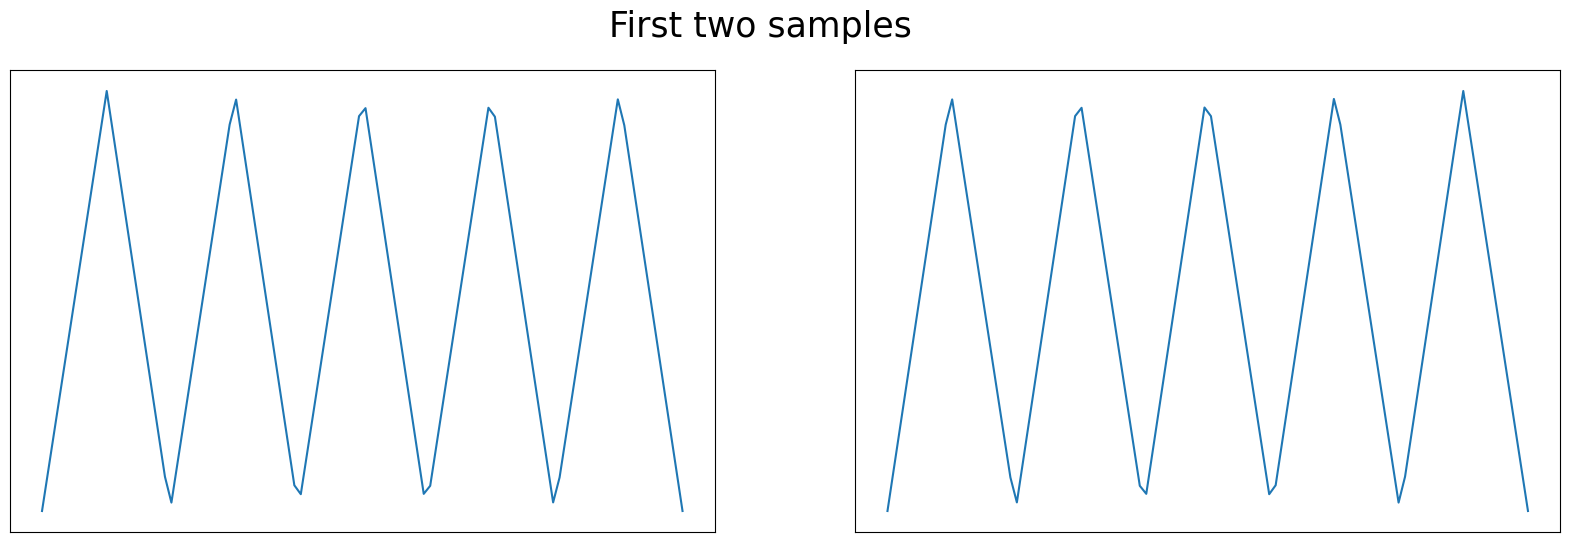

In [58]:
#Vis
fig,axes = plt.subplots(1,2,figsize=(20,6))

for i in range(2):
  axes[i].plot(data[i])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('First two samples', fontsize = 25)
plt.show()

In [59]:
data = torch.tensor(data, dtype=torch.float32)

In [60]:
#Define parameters
seq_len = 100
n_features = 1
embedding_dim = 128  # embedding_dim = latent dimension.

In [61]:
#Encoder

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim):
    super(Encoder, self).__init__()                           # embedding_dim = latent dimension.

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    # Our encoder consists two layers of LSTM


    self.rnn1 = nn.LSTM(                 # First LSTM layer
      input_size = n_features,
      hidden_size  =self.hidden_dim,
      num_layers = 1,
      batch_first = True
    )

    self.rnn2 = nn.LSTM(                 # Second LSTM layer. For second LSTM layer input is the output of first hidden_dim,
                                    # output shape of first LSTM ( seqlen x batchsize x hiddensize (features in hidden state))
      input_size = self.hidden_dim,
      hidden_size = embedding_dim,
      num_layers = 1,
      batch_first = True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))  # reshaping data to input to encoder. using batch size = 1
                                                       # data dimension = (batchsize, seq_len, inputsize)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)   # hidden ( numlayers x Batchsize x hiddensize ). For LSTM 2,hiddensize = embedd_dim

    return hidden_n.reshape((self.n_features, self.embedding_dim)) # (1 x 64)

In [62]:
#Decoder
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features # Here self.hidden_dim = 2 * 64, input_dim = 64

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features) # output layer

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)  # The output shape for second LSTM is (seqlen x batchszie x hiddensize)
    x = x.reshape((self.seq_len, self.hidden_dim)) # we reshape the output of second LSTM (seqlen x hidden)

    return self.output_layer(x)  # Since now x = (seqlen, hidden) and output linear layer = (hidden, features)
                                  # Therefore, final layer is (seqlen x features)

In [63]:
#LSTM Autoencoder

class LSTMAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim):
    super(LSTMAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [64]:
#Instance
model = LSTMAutoencoder(seq_len, n_features, embedding_dim)

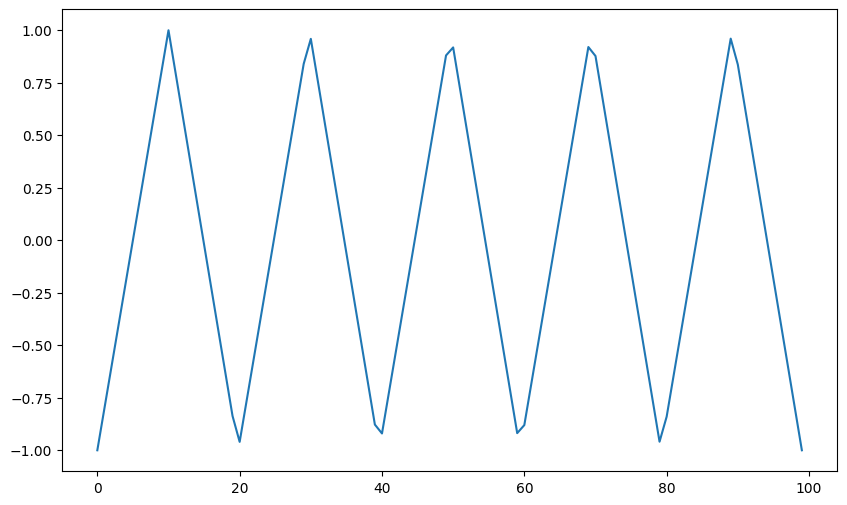

In [65]:
#Test model config by passing a sample of data
y_model = model(data[0])
plt.figure(figsize = (10,6))
plt.plot(data[0].numpy().squeeze())

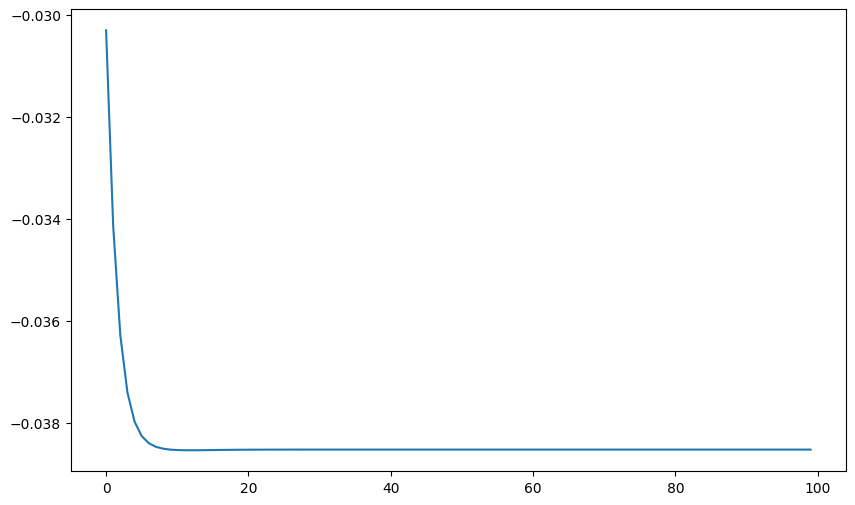

In [66]:
#Prediction without training
plt.figure(figsize = (10,6))
plt.plot(y_model.detach().numpy().squeeze()) # Since model is not trained.

In [67]:
#Parameters
lossfunc = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [68]:
epochs = 15000
losses = torch.zeros(epochs)
model = model.cuda()
for epoch in range(epochs):

  # Selecting a batchsize  of 1.

  random_idx = np.random.choice(data.shape[0], size=1)

  X = data[random_idx,:].squeeze()
  X = X.cuda()
  ypred = model(X).squeeze()
  loss = lossfunc(ypred,X) # Comparing predictions with the input data.

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 5000) == 0:

      print(f' epochs : {epoch}  loss : {loss :}')

 epochs : 0  loss : 50.55833435058594
 epochs : 5000  loss : 35.0754508972168
 epochs : 10000  loss : 13.344038009643555


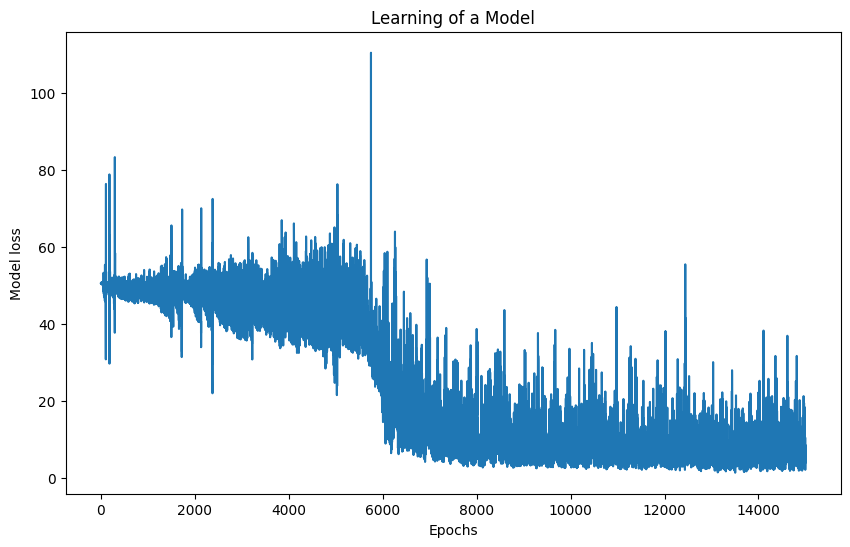

In [69]:
#Vis of model learning
plt.figure(figsize = (10,6))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [70]:
#Get pred from model
X_t = data[:10,:]  # Extracting first ten samples
X_t = X_t.cuda()

ypred_t = torch.zeros(10, seq_len)
for jj in range(10):
    d = X_t[jj,:]
    yy = model(d)
    yy = yy.T
    ypred_t[jj,:] = yy


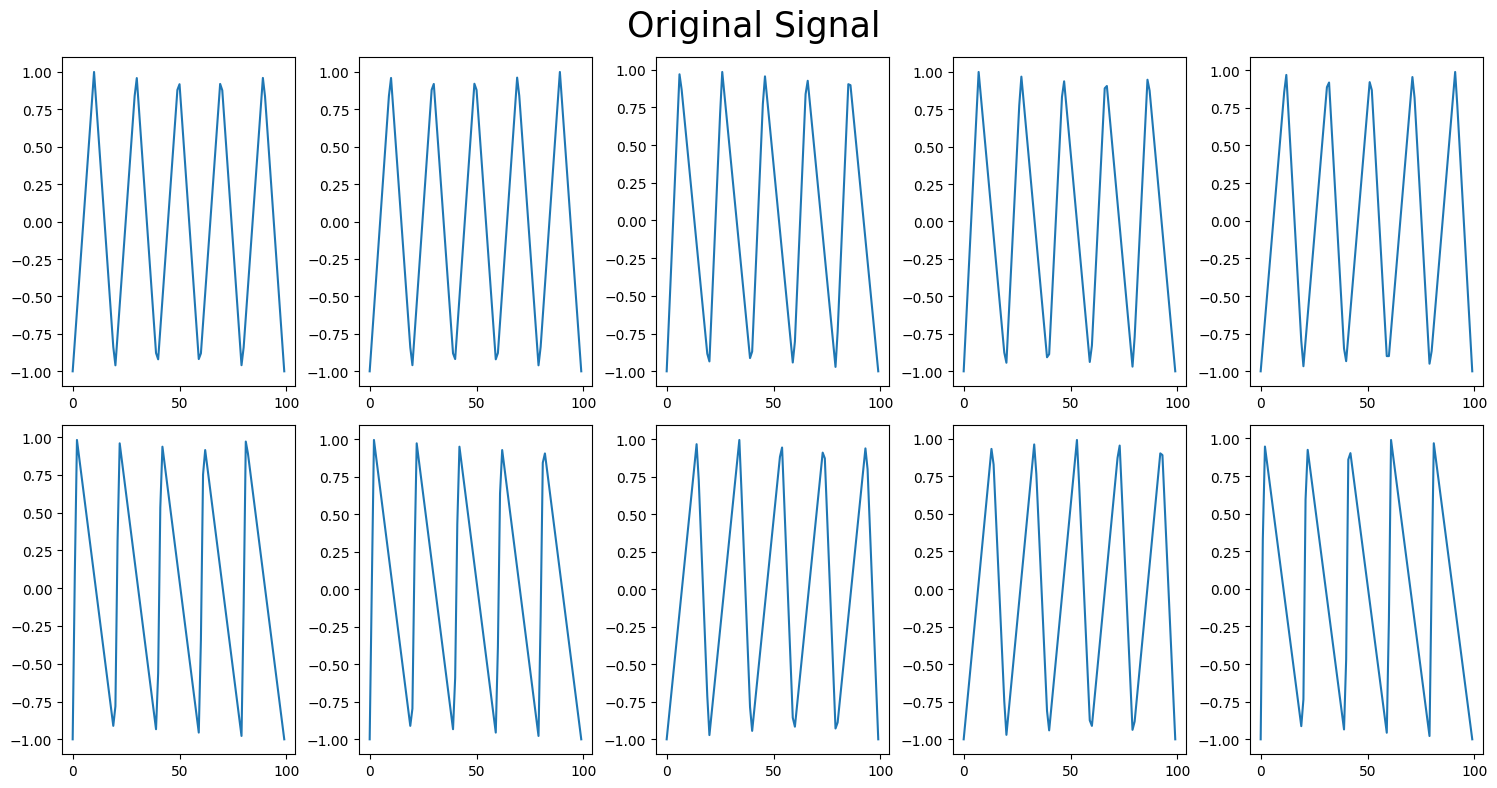

In [71]:
#Vis of original
fig, axs = plt.subplots(2,5,figsize=(15,8))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.suptitle("Original Signal", fontsize = 25)

axs[0,0].plot(X_t[0,:].detach().cpu().numpy())

axs[0,1].plot(X_t[1,:].detach().cpu().numpy())

axs[0,2].plot(X_t[2,:].detach().cpu().numpy())

axs[0,3].plot(X_t[3,:].detach().cpu().numpy())

axs[0,4].plot(X_t[4,:].detach().cpu().numpy())

axs[1,0].plot(X_t[5,:].detach().cpu().numpy())

axs[1,1].plot(X_t[6,:].detach().cpu().numpy())

axs[1,2].plot(X_t[7,:].detach().cpu().numpy())

axs[1,3].plot(X_t[8,:].detach().cpu().numpy())

axs[1,4].plot(X_t[9,:].detach().cpu().numpy())

plt.tight_layout()

plt.show()

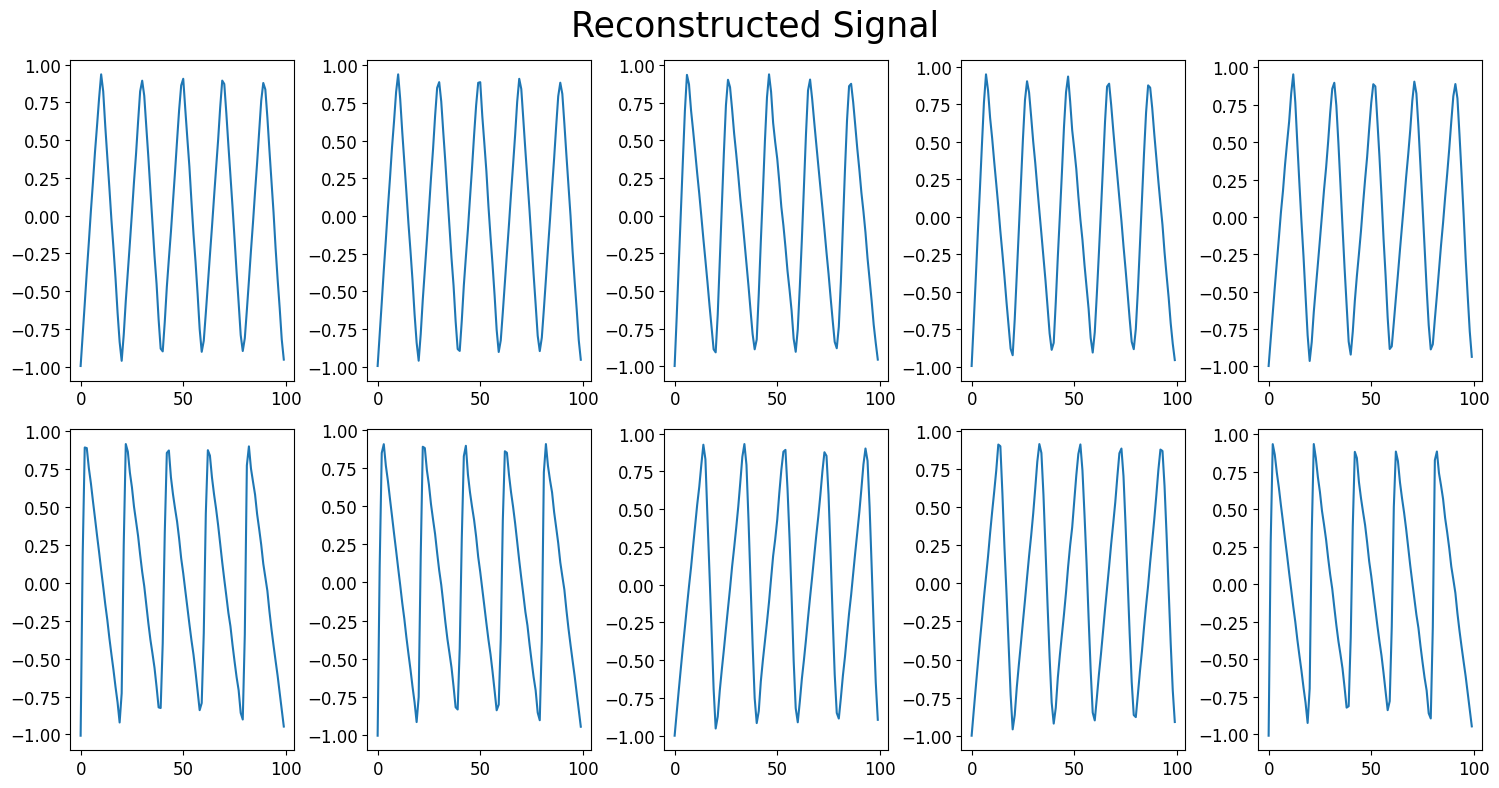

In [72]:
#Vis of reconstructed
fig, axs = plt.subplots(2,5,figsize=(15,8))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.suptitle("Reconstructed Signal", fontsize = 25)

axs[0,0].plot(ypred_t[0,:].detach().cpu().numpy())

axs[0,1].plot(ypred_t[1,:].detach().cpu().numpy())

axs[0,2].plot(ypred_t[2,:].detach().cpu().numpy())

axs[0,3].plot(ypred_t[3,:].detach().cpu().numpy())

axs[0,4].plot(ypred_t[4,:].detach().cpu().numpy())

axs[1,0].plot(ypred_t[5,:].detach().cpu().numpy())

axs[1,1].plot(ypred_t[6,:].detach().cpu().numpy())

axs[1,2].plot(ypred_t[7,:].detach().cpu().numpy())

axs[1,3].plot(ypred_t[8,:].detach().cpu().numpy())

axs[1,4].plot(ypred_t[9,:].detach().cpu().numpy())

plt.tight_layout()

plt.show()